<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/Visualizing_Function_Space_Similarity_ResNet20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up and imports

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
# Which GPU?
!nvidia-smi

Wed Jul 15 08:57:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

In [6]:
# Other imports
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook
from numpy.linalg import norm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

## Retrieve the trained models

**ResNet20v1 with data augmentation**

In [ ]:
!mkdir ResNet20v1_CIFAR10_Aug
!gsutil -m cp -r gs://losslandscape/ResNet20v1_CIFAR10_Aug/ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_*.h5 ResNet20v1_CIFAR10_Aug/

In [70]:
model_ckpts = os.listdir('ResNet20v1_CIFAR10_Aug')
print(len(model_ckpts))

40


In [71]:
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [72]:
model_ckpts = sorted_nicely(model_ckpts)
model_ckpts[:5]

['ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_0.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_1.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_2.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_3.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_4.h5']

## Create data loaders

In [73]:
# Load the training set of CIFAR10
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_test = y_test.flatten()

In [74]:
BATCH_SIZE = 128

def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label


test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Disagreement of predictions

In [75]:
def evaluate(test_dataloader, model):
  true_labels = []
  pred_labels = []
  
  for imgs, labels in iter(test_ds):
    preds = model.predict(imgs)
    
    true_labels.extend(labels)
    pred_labels.extend(np.argmax(preds, axis=1))

  return np.array(true_labels), np.array(pred_labels)

In [77]:
predictions = []
for i in tqdm_notebook(range(len(model_ckpts))):
  # load model
  model = tf.keras.models.load_model('/content/ResNet20v1_CIFAR10_Aug/' + model_ckpts[i])
  # get predictions for model
  _, preds = evaluate(test_ds, model)

  predictions.append(preds)

In [78]:
empty_arr = np.zeros(shape=(40, 40))

for i in tqdm_notebook(range(40)):
  preds1 = predictions[i]
  for j in range(i, 40):
    preds2 = predictions[j]
    
    # compute dissimilarity
    dissimilarity_score = 1-np.sum(np.equal(preds1, preds2))/10000 
    
    empty_arr[i][j] = dissimilarity_score
    if i is not j:
      empty_arr[j][i] = dissimilarity_score

dissimilarity_coeff = empty_arr[::-1]

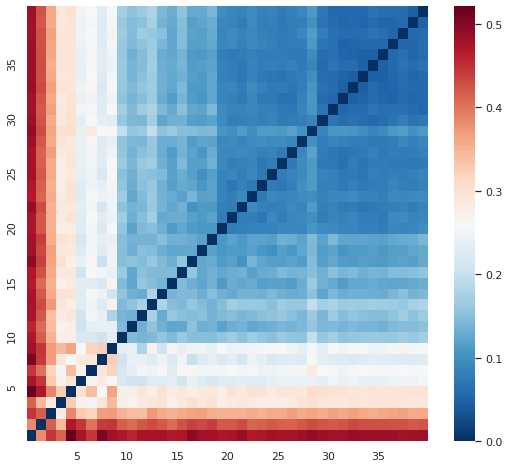

In [79]:
plt.figure(figsize=(9,8))
sns_plot = sns.heatmap(dissimilarity_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);
plt.show()

figure = sns_plot.get_figure()    
figure.savefig('prediction_disagreement.png')

## Cosine similarity of weights

In [80]:
def get_model_weights(model):
  model_weights = []
  for layer in model.layers:
    weights = layer.get_weights()
    if len(weights)==0:
      continue
    model_weights.extend(np.array(weights[0]).flatten()) 

  return np.array(model_weights)

In [84]:
weights_of_models = []
for i in tqdm_notebook(range(40)):
  # load model
  model = tf.keras.models.load_model('/content/ResNet20v1_CIFAR10_Aug/' + model_ckpts[i])
  # get predictions for model
  weights = get_model_weights(model)

  weights_of_models.append(weights)

In [85]:
empty_arr = np.zeros(shape=(40, 40))

for i in tqdm_notebook(range(40)):
  weights1 = weights_of_models[i]
  for j in range(i, 40):
    weights2 = weights_of_models[j]
    
    # compute cosine similarity of weights
    cos_sim = np.dot(weights1, weights2)/(norm(weights1)*norm(weights2))
    
    empty_arr[i][j] = cos_sim
    if i is not j:
      empty_arr[j][i] = cos_sim

cos_sim_coeff = empty_arr[::-1]

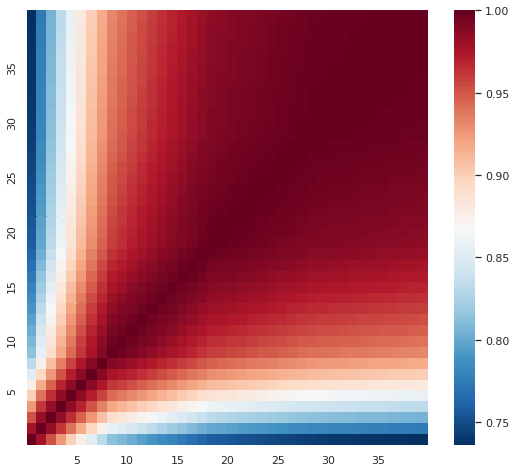

In [86]:
plt.figure(figsize=(9,8))
sns_plot = sns.heatmap(cos_sim_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);
plt.show()

figure = sns_plot.get_figure()    
figure.savefig('functional_similarity.png')

In [87]:
wandb.init(project='loss-landscape', id='resnet20v1_aug_investigations')
wandb.log({'prediction_disagreement': wandb.Image('prediction_disagreement.png')})
wandb.log({'functional_similarity': wandb.Image('functional_similarity.png')})